In [3]:
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *

In [4]:
PATH = "D:\\dataset_seg\\dicom"

In [5]:
dicomImg = pydicom.read_file(PATH + "\\image001.dcm")
dicomImg

(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY ']
(0008, 0016) SOP Class UID                       UI: Multi-frame Grayscale Word Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.1125.4548578464122090360290441988941817585
(0008, 0020) Study Date                          DA: '20190528'
(0008, 0030) Study Time                          TM: '130703.629855'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'OT'
(0008, 0090) Referring Physician's Name          PN: ''
(0010, 0010) Patient's Name                      PN: ''
(0010, 0020) Patient ID                          LO: ''
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: ''
(0020, 000d) Study Instance UID                  UI: 1.2.826.0.1.3680043.2.1125.3228272720357417447778365854897430376
(0020, 000e) Series Instance UID               

In [6]:
#thickness = 2.90120005607605 - 1.45060002803802
thickness = 1.45060002803802 - 0

In [7]:
path = PATH + "\\test"
slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
slices.sort(key = lambda x: int(x.InstanceNumber))

for s in slices:
    s.SliceThickness = thickness

In [8]:
slices[0]

(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY ']
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.1125.1784636766910677697060938602239080500
(0008, 0020) Study Date                          DA: '20190528'
(0008, 0030) Study Time                          TM: '132330.646514'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'OT'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0010, 0010) Patient's Name                      PN: ''
(0010, 0020) Patient ID                          LO: ''
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: ''
(0018, 0050) Slice Thickness                     DS: "1.45060002803802"
(0018, 2010) Nominal Scanned Pixel Spacing       DS: ['1', '1

In [3]:
import SimpleITK as sitk
itkImg1 = sitk.ReadImage('D:\\dataset_seg\\xVertSeg.v1\\Data1\\images\\image001.mhd')
slices1 = sitk.GetArrayViewFromImage(itkImg1)
for i in range(200):
    slices[i].PixelArray = sitk.GetArrayViewFromImage(itkImg)[i, :, :]

(0.41362, 0.41362, 1.4506)


'slices1 = sitk.GetArrayViewFromImage(itkImg1)\nfor i in range(200):\n    slices[i].PixelArray = sitk.GetArrayViewFromImage(itkImg)[i, :, :]'

In [10]:
i = np.array(slices[0].PixelArray)
#plt.imshow(segment(i), cmap="gray")

In [11]:
def get_pixels_hu(scans):
    image = np.stack([s.PixelArray for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [12]:
imgs = get_pixels_hu(slices)

In [13]:
for s in slices:
    if s.RescaleSlope != 1:
        print(s.RescaleSlope)
    if s.RescaleIntercept != 0:
        print(s.RescaleIntercept)

In [14]:
np.save(PATH + "\\image001_Data.npy", imgs)

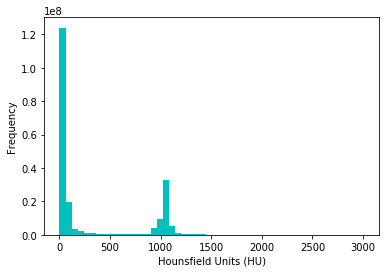

In [24]:
file_used=PATH + "\\image001_Data.npy" 
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

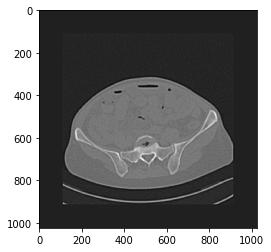

In [55]:
import cv2
#plt.hist(imgs_to_process[0].flatten(), bins=50, color='c')
#tmp = np.array(imgs_to_process[0])

itkImg2 = sitk.ReadImage('D:\\dataset_seg\\xVertSeg.v1\\Data1\\images\\image002.mhd')
slices2 = sitk.GetArrayViewFromImage(itkImg2)
tmp = sitk.GetArrayViewFromImage(itkImg2)[242, :, :]


#f = scipy.misc.face(gray=True).astype(float)
blurred_f = scipy.ndimage.gaussian_filter(tmp, 3)
filter_blurred_f = scipy.ndimage.gaussian_filter(blurred_f, 1)
alpha = 30
sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)

plt.imshow(sharpened, cmap="gray")

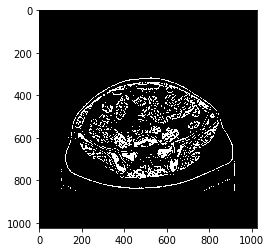

In [81]:
tmp = np.array(sharpened)
tmp[((tmp > 1100) & (tmp < 1300))] = True
tmp[tmp != True] = False
tmp[850:, :] = False
plt.imshow(tmp, cmap="gray")

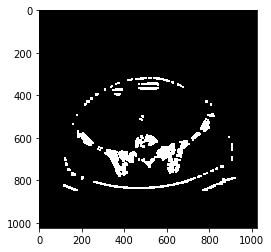

In [79]:
t = np.array(sharpened)
t[((t > 1180) & (t < 1250))] = True
t[t != True] = False
t[850:, :] = False
t = morphology.dilation(t,np.ones([10,10]))
t = morphology.erosion(t, np.ones([3,3]))
#tmp = morphology.erosion(tmp,np.ones([13,13]))
t = morphology.opening(t,np.ones([10,10]))
plt.imshow(t, cmap="gray")

In [39]:
#Convert prob map to B&W
def conv(x):    
    a = x[:, 0]
    b = x[:, 1]
    a[a == 0] = False
    a[a == 1] = True
    return a

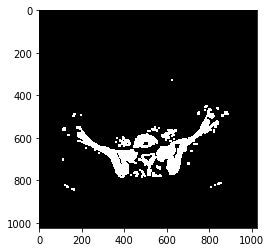

In [40]:
#tmp = np.array(imgs_to_process[100])
#tmp = np.array(sharpened)
tmp = np.array(tmp)
tmp[((tmp > 1100) & (tmp < 1300))] = True
#tmp[((tmp > 2000) & (tmp < 2005))] = True
#tmp[tmp < 2000] = True
#tmp[tmp < 1000] = True
#tmp[tmp > 2000] = False
#tmp[tmp > 1000].shape
#tmp = np.where(((tmp > 1000) & (tmp < 2000)), True, False)
tmp[tmp != True] = False
tmp[850:, :] = False
#tmp = morphology.erosion(tmp,np.ones([3,3]))
#tmp = morphology.dilation(tmp,np.ones([8,8]))

'''tmp = KMeans(n_clusters=2).fit_transform(np.reshape(tmp,[np.prod(tmp.shape),1]))
#kmeans = KMeans(n_clusters=2).fit(np.reshape(tmp,[np.prod(tmp.shape),1]))
#centers = sorted(kmeans.cluster_centers_.flatten())
#threshold = np.mean(centers)
#tmp = np.where(tmp<threshold,0.0,1.0)

tmp = np.reshape(conv(tmp), [-1, 1024])'''
tmp = morphology.dilation(tmp,np.ones([10,10]))
tmp = morphology.erosion(tmp, np.ones([3,3]))
#tmp = morphology.erosion(tmp,np.ones([13,13]))
tmp = morphology.opening(tmp,np.ones([10,10]))
plt.imshow(tmp, cmap="gray")

In [41]:
def segment(img):
    tmp = img
    tmp[((tmp > 1100) & (tmp < 1300))] = True
    tmp[tmp != True] = False
    tmp[850:, :] = False
    '''tmp = morphology.erosion(tmp,np.ones([3,3]))
    tmp = morphology.dilation(tmp,np.ones([5,5]))
    tmp = morphology.dilation(tmp,np.ones([10,10]))
    tmp = morphology.erosion(tmp,np.ones([13,13]))
    #tmp = morphology.opening(tmp,np.ones([10,10]))'''
    tmp = morphology.erosion(tmp, np.ones([3,3]))
    tmp = morphology.dilation(tmp,np.ones([10,10]))
    tmp = morphology.opening(tmp,np.ones([10,10]))
    #tmp = morphology.closing(tmp, np.ones([6,6]))
    return tmp

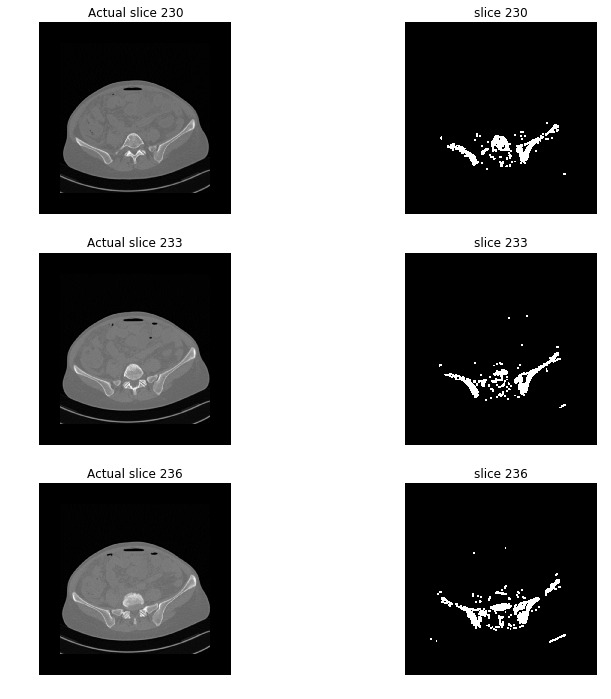

In [45]:
def sample_stack(stack, rows=3, start_with=230, show_every=3):
    fig,ax = plt.subplots(rows,2,figsize=[12,12])
    for i in range(rows):
        ind = start_with + i*show_every
        ax[int(i),int(0)].set_title('Actual slice %d' % ind)
        ax[int(i),int(0)].imshow(slices2[ind],cmap='gray')
        #ax[int(i),int(0)].imshow(slices[ind].PixelArray,cmap='gray')
        ax[int(i),int(0)].axis('off')
        ax[int(i),int(1)].set_title('slice %d' % ind)
        ax[int(i),int(1)].imshow(segment(stack[ind]),cmap='gray')
        ax[int(i),int(1)].axis('off')
    plt.show()

#sample_stack(imgs_to_process)
sample_stack(slices2)

In [50]:
#processedImgs = np.array(imgs_to_process)
processedImgs = np.array(slices2)
for i in range(processedImgs.shape[0]):
    processedImgs[i] = segment(processedImgs[i])

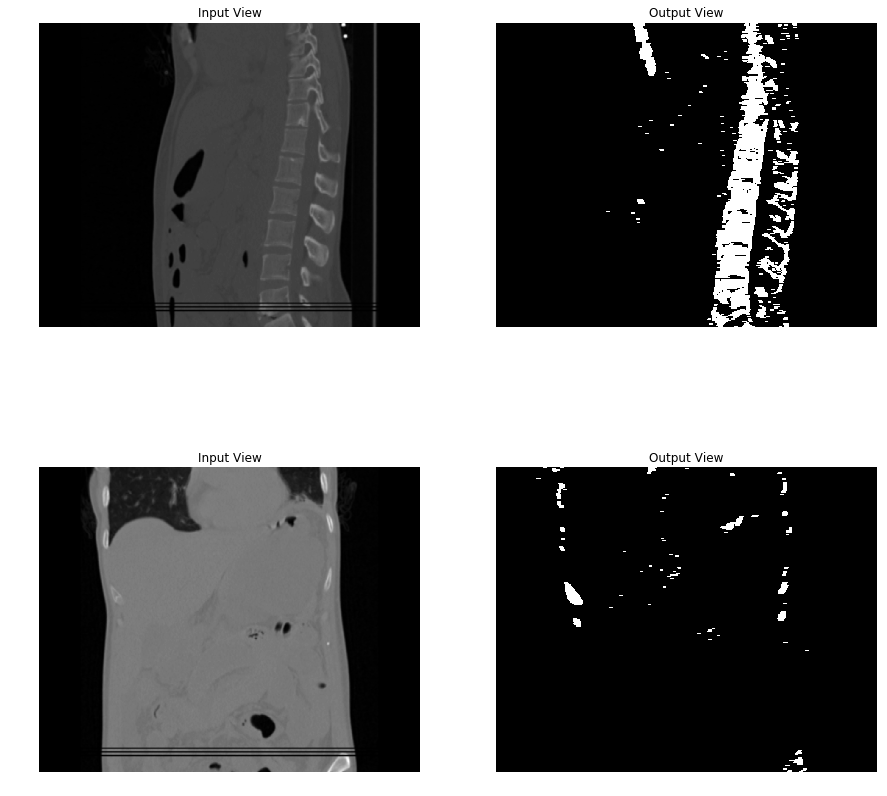

In [51]:
#ip1 = slices1[:, :, 500]
ip1 = slices2[:, :, 500]
ip1 = cv2.resize(ip1, (1280, 1024))
op1 = processedImgs[:, :, 500]
op1 = cv2.resize(op1, (1280, 1024))
ip2 = slices2[:, 500, :]
#ip2 = slices1[:, 500, :]
ip2 = cv2.resize(ip2, (1280, 1024))
op2 = processedImgs[:, 500, :]
op2 = cv2.resize(op2, (1280, 1024))

fig,ax = plt.subplots(2,2,figsize=[15,15])
ax[0,0].set_title('Input View')
ax[0,0].imshow(ip1, cmap='gray')
ax[0,0].axis('off')
ax[0,1].set_title('Output View')
ax[0,1].imshow(op1, cmap='gray')
ax[0,1].axis('off')
ax[1,0].set_title('Input View')
ax[1,0].imshow(ip2, cmap='gray')
ax[1,0].axis('off')
ax[1,1].set_title('Output View')
ax[1,1].imshow(op2, cmap='gray')
ax[1,1].axis('off')
plt.show()

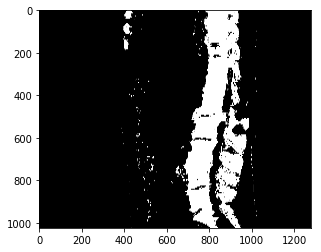

In [184]:
ilastikOut = sitk.ReadImage("D:\\dataset_seg\\output\\out.mhd")
plt.imshow(cv2.resize(sitk.GetArrayViewFromImage(ilastikOut)[:, :, 500], (1280, 1024)), cmap="gray")

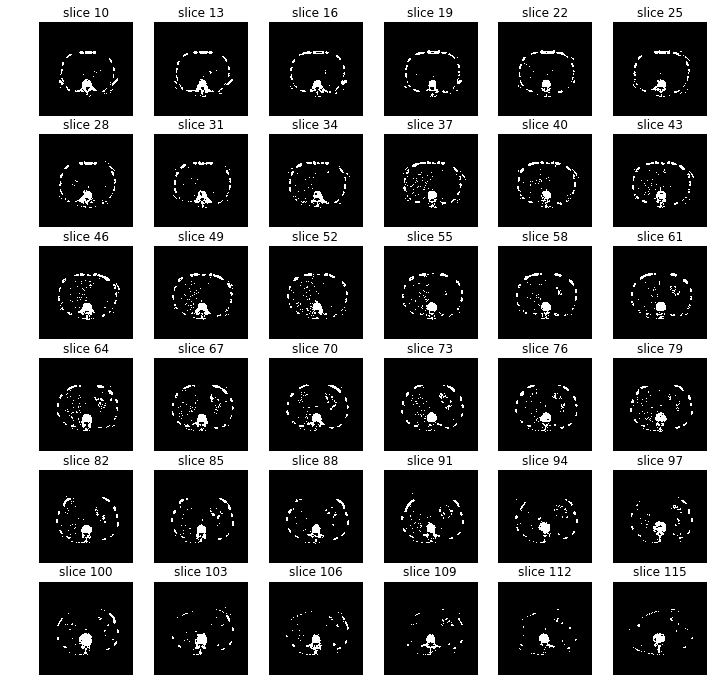

In [185]:
#id = 0
#imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(segment(stack[ind]),cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

In [17]:
slices[0].PixelSpacing = ['0.413619995117188', '0.413619995117188']
[slices[0].PixelSpacing[0], slices[0].PixelSpacing[1], slices[0].SliceThickness]

["0.413619995117188", "0.413619995117188", "1.45060002803802"]

In [18]:
#imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([slices[0].PixelSpacing[0], slices[0].PixelSpacing[1], slices[0].SliceThickness]))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, slices, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)

Shape before resampling	 (200, 1024, 1024)
Shape after resampling	 (83, 424, 1485)


In [19]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 0, 0]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((0.2, 0.2, 0.2))
    plt.show()

Transposing surface
Calculating surface
Drawing


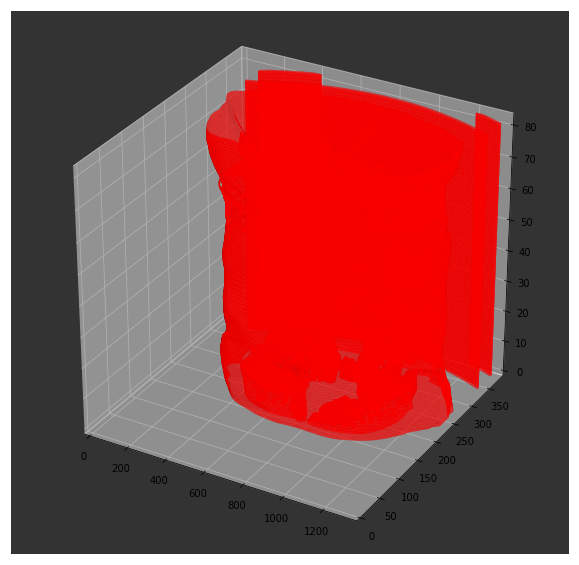

In [123]:
v, f = make_mesh(imgs_after_resamp, 350)
plt_3d(v, f)

In [ ]:
#interactive 3d plot, please don't execute, takes 10 min atleast, plus eats your ram

v, f = make_mesh(imgs_after_resamp, 350, 2)
plotly_3d(v, f)

In [177]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

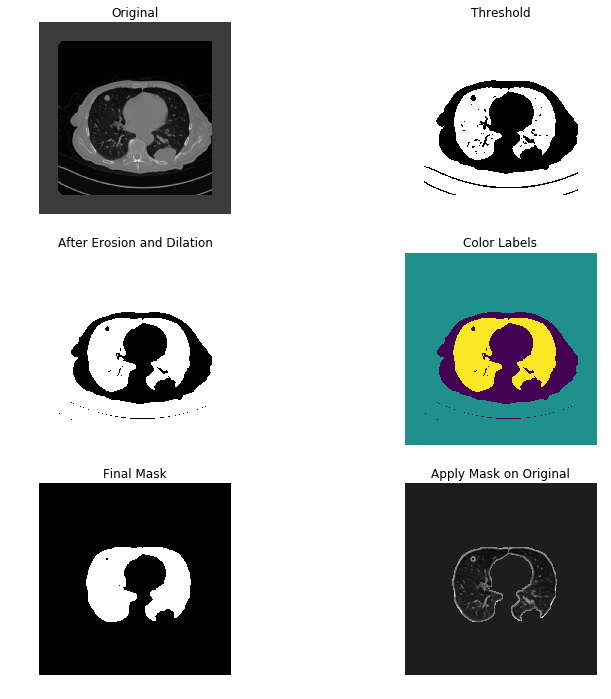

In [178]:
img = imgs_to_process[0]
maskximg = make_lungmask(img, display=True)

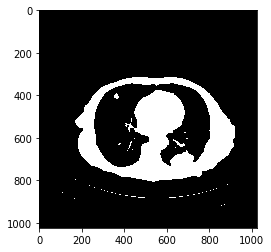

In [182]:
row_size= img.shape[0]
col_size = img.shape[1]

mean = np.mean(img)
std = np.std(img)
img = img-mean
img = img/std
# Find the average pixel value near the lungs
# to renormalize washed out images
middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
mean = np.mean(middle)  
max = np.max(img)
min = np.min(img)
# To improve threshold finding, I'm moving the 
# underflow and overflow on the pixel spectrum
img[img==max]=mean
img[img==min]=mean
#
# Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
#
kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)
thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

# First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
# We don't want to accidentally clip the lung.

eroded = morphology.erosion(thresh_img,np.ones([3,3]))
dilation = morphology.dilation(eroded,np.ones([8,8]))

dilation = cv2.bitwise_not(dilation)
plt.imshow(dilation, cmap="gray")

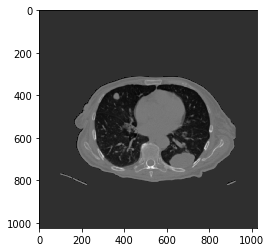

In [183]:
labels = measure.label(dilation) # Different labels are displayed in different colors
label_vals = np.unique(labels)
regions = measure.regionprops(labels)
good_labels = []
for prop in regions:
    B = prop.bbox
    if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
        good_labels.append(prop.label)
mask = np.ndarray([row_size,col_size],dtype=np.int8)
mask[:] = 0

#
#  After just the lungs are left, we do another large dilation
#  in order to fill in and out the lung mask 
#
for N in good_labels:
    mask = mask + np.where(labels==N,1,0)
mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

plt.imshow(mask*img, cmap="gray")

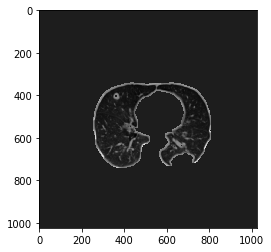

In [22]:
plt.imshow(maskximg, cmap="gray")